# DistilBERT & RoBERTa 

This notebook has been developed to train and make inferences with both DistilBERT and RoBERTa.

Import the required libraries. In order to run this cell, the user must first pip install the requirements.txt file

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
from transformers import TFDistilBertModel, DistilBertTokenizerFast, RobertaTokenizer, TFRobertaModel
import matplotlib.pyplot as plt
from helpers import *
from implementations import *
import pickle
from keras.models import model_from_json

To speed up the training and inferencing procedure we made use of the TPUs available on Google Colab. If you want to run this code on Google Colab, uncomment the cell below

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Load the data and set the required constants. Default values correspond to our best model

In [10]:
# Small dataset (200'000 observations)
POS_TRAINING_PATH = "train_pos.txt"
NEG_TRAINING_PATH = "train_neg.txt"

# Full dataset (2.2 million obsevations)
POS_TRAINING_PATH_FULL = "train_pos_full.txt"
NEG_TRAINING_PATH_FULL = "train_neg_full.txt"

# Test data
TEST_PATH = "test_data.txt"

# choose model to run 
RUN_DISTILBERT = False
RUN_ROBERTA = True

# set the required constants
RANDOM_STATE = 123
MAX_LENGTH=55
LAYER_DROPOUT = 0.6
LEARNING_RATE = 1e-5
TRAIN_EPOCHS = 2         # number of epochs to tune the full model (including the Transformer model used)
FINE_TUNE_EPOCHS = 1     # number of epochs of finetuning the Neural Network classifier
BATCH_SIZE = 128
USE_LSTM = False         # set to True if you want to run the model with Bi-directional LSTMS on top of the embeddings

# Load either small or full training sets
# df_small = loadData(POS_TRAINING_PATH, NEG_TRAINING_PATH)
df_full = loadData(POS_TRAINING_PATH_FULL, NEG_TRAINING_PATH_FULL)

In [11]:
# Load the test set.
test_sent = []
idx = []
with open(TEST_PATH) as test:
    for line in test:
        split = line.split(",", 1)
        idx.append(int(split[0]))
        test_sent.append(split[1])

data = {'index':idx,'tweet':test_sent}
df_test = pd.DataFrame(data)
df_test.head()

,index,tweet
0,1,sea doo pro sea scooter ( sports with the port...
1,2,<user> shucks well i work all week so now i ca...
2,3,i cant stay away from bug thats my baby\n
3,4,<user> no ma'am ! ! ! lol im perfectly fine an...
4,5,"whenever i fall asleep watching the tv , i alw..."


In [ ]:
# sanity check
df_full.head(-10)

,tweet,sentiment
0,<user> i dunno justin read my mention or not ....,1
1,"because your logic is so dumb , i won't even c...",1
2,""" <user> just put casper in a box ! "" looved t...",1
3,<user> <user> thanks sir > > don't trip lil ma...,1
4,visiting my brother tmr is the bestest birthda...,1
...,...,...
2270467,"tomarrow we would have to do the "" impossible ...",0
2270468,<user> hell yeah and my.phone is huge it hurt ...,0
2270469,<user> i really wish i could be in london now ...,0
2270470,"<user> i know , i can't help it though - i've ...",0


### Tokenization 
We initialize both the DistilBERT and RoBERTa specific base tokenizers

In [12]:
# DistilBERT tokenizer
tokenizer_distilBERT = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# RoBERTa
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

Both DistilBERT and RoBERTa require to set a max_length parameter corresponding to the max number of tokens in the sentences. If this is not set by the user, the models will initialize it to the largest number possible, i.e. 512. In order to avoid rendering the models havier to run, we perform a quick analysis to find the distribution of the number of tokens in the sentences.

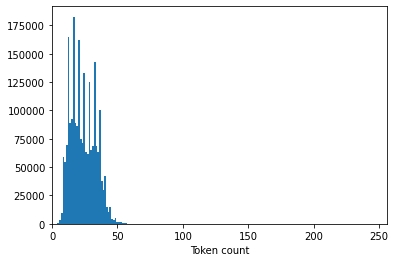

In [ ]:
def get_max_token(tokenizer):
    token_lens = []

    for txt in df_full.tweet:
        tokens = tokenizer.encode(txt, max_length=512)
        token_lens.append(len(tokens))

    plt.hist(token_lens, bins = 100)
    plt.xlim([0, 256]);
    plt.xlabel('Token count');

get_max_token(tokenizer_roberta)

It can be seen that, based on the RoBERTa tokenizer, most of the tweets have less than 55 tokens. A very similar histogram is found using DistilBERT. For this reason, later we will set the max_length parameter to 55.

Select part of the training set as validation set to keep track of the model performance on unseen data

In [13]:
training = df_full.sample(frac=1,random_state=123) 
train = training.sample(frac=0.995,random_state=123) 
val = training.drop(train.index) # approximately 10000 observations, representing the real test set

Obtain the indeces represenitng each token in the model's vocabulary and the attention masks requried as input for the Transformer model.

In [15]:
# DistilBERT
if RUN_DISTILBERT == True:
    training_ids, training_attention = batch_encode(tokenizer_distilBERT, train.tweet.to_list())
    val_ids, val_attention = batch_encode(tokenizer_distilBERT, val.tweet.to_list())

# RoBERTa
if RUN_ROBERTA == True:
    training_ids, training_attention = batch_encode(tokenizer_roberta, train.tweet.to_list())
    val_ids, val_attention = batch_encode(tokenizer_roberta, val.tweet.to_list())

In [ ]:
# check that the attention masks are indeed binary
training_attention

<tf.Tensor: shape=(180414, 60), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
# sanity check
training_ids

<tf.Tensor: shape=(180414, 60), dtype=int32, numpy=
array([[    0, 17036, 10715, ...,     1,     1,     1],
       [    0, 20982, 17487, ...,     1,     1,     1],
       [    0,   118, 42898, ...,     1,     1,     1],
       ...,
       [    0, 10431,  1970, ...,     1,     1,     1],
       [    0, 41552, 12105, ...,     1,     1,     1],
       [    0, 41552, 12105, ...,     1,     1,     1]], dtype=int32)>

In [ ]:
def build_model(transformer, max_length=MAX_LENGTH):
    """
    Build the model we developed

    Input:
        - transformer:  the Transformer model to be used (either DistilBERT or RoBERTa)
        - use_LSTM:     boolean indicating whether the model with the bidirectional LSTM layers should be used
        - max_length:   maximum number of tokens per sentence (default=55)
    Output:
        - model:  the built model ready to be compiled and trained
    """

    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=RANDOM_STATE)

    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),
                                          name='input_ids',
                                          dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,),
                                                name='input_attention',
                                                dtype='int32')

    # Access the last layer of the Transformer model.
    # It is a tf.Tensor of shape (batch_size, max_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # From the last layer, we select the embedding of the [CLS] token
    cls_token = last_hidden_state[:, 0, :]

    # include 2 bi-direction LSTM layers
    if USE_LSTM == True:
        # obtain the vector representation of each word (do not select the [CLS] and [SEP] special tokens)
        embeddings = last_hidden_state[:, 1:-1, :]
        X = tf.keras.layers.Dropout(LAYER_DROPOUT, seed=RANDOM_STATE)(embeddings)
        # Bi-LSTM layers 
        X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=1024, kernel_initializer=weight_initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-2, l2=1e-3), bias_initializer='zeros', return_sequences=True), merge_mode='ave')(X)
        X = tf.keras.layers.Dropout(LAYER_DROPOUT, seed=RANDOM_STATE)(X)
        X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=1024, kernel_initializer=weight_initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-2, l2=1e-3), bias_initializer='zeros', return_sequences=False), merge_mode='ave')(X)
        X = tf.concat([cls_token, X], axis=1)
    else:
        X = cls_token
        
    # Build the 2-layers MLP classifier
    X = tf.keras.layers.Dropout(LAYER_DROPOUT, seed=RANDOM_STATE)(X)
    X = tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.01), kernel_initializer=weight_initializer, bias_initializer='zeros')(X)
    X = tf.keras.layers.Dropout(LAYER_DROPOUT, seed=RANDOM_STATE)(X)
    X = tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0001, l2=0.01), kernel_initializer=weight_initializer, bias_initializer='zeros')(X)
    X = tf.keras.layers.Dropout(LAYER_DROPOUT, seed=RANDOM_STATE)(X)

    # Construct the output layer (for binary classification)
    output = tf.keras.layers.Dense(1,
                                  activation='sigmoid',
                                  kernel_initializer=weight_initializer,
                                  kernel_constraint=None,
                                  bias_initializer='zeros'
                                  )(X)

    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)

    return model

Compile the model and run the training

In [49]:
NUM_STEPS = len(train.index) // BATCH_SIZE

# Uncomment the following line to use the TPU settings if running the code on Google Colab
# with tpu_strategy.scope():

# DistilBERT
if RUN_DISTILBERT == True:
    tokenizer_distilBERT = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# roBERTa
elif: RUN_ROBERTA == True:
    tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
    model = TFRobertaModel.from_pretrained('roberta-base')

# Set the Transformer layers to be trainable
for layer in model.layers:
    layer.trainable = True
model = build_model(model)

# compile the model using Adam optimizer
model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.95, beta_2=0.95),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# check the model is well initialized by printing a summary of it 
print(model.summary())

# Train the full model including the Transformer parameters
train_history1 = model.fit(
  x = [training_ids, training_attention],
  y = train.sentiment.to_numpy(),
  epochs = FINE_TUNE_EPOCHS,
  batch_size = BATCH_SIZE,
  steps_per_epoch = NUM_STEPS,
  validation_data = ([val_ids, val_attention], val.sentiment.to_numpy()),
  verbose=2
)

# After training the full model, we freeze the Transformer layers and fine-tune the MLP classifier only
model.get_layer(index=2).trainable = False

# check if the freezing worked well
print(model.summary())

# Fine-tune the MLP classifier
train_history2 = model.fit(
  x = [training_ids, training_attention],
  y = train.sentiment.to_numpy(),
  epochs = TRAIN_EPOCHS,
  batch_size = BATCH_SIZE,
  steps_per_epoch = NUM_STEPS,
  validation_data = ([val_ids, val_attention], val.sentiment.to_numpy()),
  verbose=2
)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init_

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 55)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 55)]         0           []                               
                                                                                                  
 tf_roberta_model_6 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thPoolingAndCrossAt               'input_attention[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 55,                                          

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 55) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 55) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 55) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 55) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 55) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 55) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None,) dtype=int64>]


17082/17082 - 1753s - loss: 2.5236 - accuracy: 0.8724 - val_loss: 0.2980 - val_accuracy: 0.8912 - 1753s/epoch - 103ms/step
Epoch 2/2
17082/17082 - 1699s - loss: 0.2721 - accuracy: 0.8957 - val_loss: 0.2559 - val_accuracy: 0.8976 - 1699s/epoch - 99ms/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 55)]         0           []                               
                                                                                                  
 input_attention (InputLayer)   [(None, 55)]         0           []                               
                                                                                                  
 tf_roberta_model_6 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 odel)                          thP

### Inference

First, we encode the test sentences the same way we did for the training data

In [ ]:
# DistilBERT
if RUN_DISTILBERT == True:
    test_ids, test_attention = batch_encode(tokenizer_distilBERT, df_test.tweet.to_list())
    
# RoBERTa
if RUN_ROBERTA == True:
    test_ids, test_attention = batch_encode(tokenizer_roberta, df_test.tweet.to_list())

The we make the predictions using the trained model. The model predicts probabilities which we map to binary values 1 and -1 using the natural 0.5 threshold

In [19]:
pred = model.predict([test_ids, test_attention])
pred[pred>0.5] = 1
pred[pred<=0.5] = -1

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 55) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 55) dtype=int32>]


Create submission file

In [22]:
OUTPUT_PATH = 'submission_to_AIcrowd'
create_csv_submission(df_test['index'], pred, OUTPUT_PATH)

## Save the model for future applications 

In [55]:
model.save_weights('./RoBERTa_finetuned_MLP2_weights.h5') 

In [56]:
model_json = model.to_json()
with open("RoBERTa_finetuned_MLP2.json", "w") as json_file:
    json_file.write(model_json)

## Load already-trained model 

In [42]:
json_file = open('RoBERTa_finetuned_MLP2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={'TFRobertaModel': TFRobertaModel})
loaded_model.load_weights('./RoBERTa_finetuned_MLP2_weights.h5')